## run imports

In [1]:
import ingredient_preprocessor as ip
import ingredient_indexing as ingredient_indexing
from food_ranker import *
import food_indexing as food_indexing
import food_preprocessor as fp
from importlib import reload
import matplotlib.pyplot as plt

/Users/jonathan/git_repos/si650-final-project/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## run constants

In [2]:
STOPWORDS_PATH = 'stopwords.txt'
DATASET_PATH = 'cleanedRecipes.jsonl'
INGREDIENT_INDEX_PATH = 'ingredient_index'
FOOD_INDEX_PATH = 'food_index'
ID_TO_RECIPE_PATH = 'id_to_recipe.json'
ANNOTATED_PATH = 'annotations.csv'

## ONLY RUN THIS IF IT DOESN'T EXIST FOR YOU YET IN YOUR PROJECT DIRECTORY: build a doc id to doc info JSON for quick loading in CLI

In [4]:
id_to_recipe = {}  # make doc id to info dict for quick loading

with open(DATASET_PATH, 'r') as recipes_read:
    for recipe in recipes_read:
        recipe = json.loads(recipe)
        recipe_id = recipe['recipeID']
        recipe_title = recipe['title']
        recipe_link = recipe['link']
        recipe_NERs = recipe['NER']
        id_to_recipe[recipe_id] = (recipe_title, recipe_link, recipe_NERs)

with open(ID_TO_RECIPE_PATH, 'w') as json_out:
    json_data = json.dumps(id_to_recipe, indent=4)
    
    json_out.write(json_data)

## OR LOAD IT INSTEAD

In [3]:
with open(ID_TO_RECIPE_PATH, 'r') as json_file:
    id_to_recipe = json.load(json_file)

In [4]:
idk = '1394448'
print(id_to_recipe[idk])

[nan, 'food52.com/recipes/57431-none', '["bacon"]']


## build ingredient tokenizer, stopwords, food tokenizer

In [5]:
ingredient_preprocessor = ip.SplitTokenizer()
ingredient_preprocessor.tokenize("This is a test sentences, with a comma...., chicken breasts")

['this is a test sentence', 'with a comma', 'chicken breast']

In [6]:
stopwords = set()
with open(STOPWORDS_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 610'

In [7]:
# stopwords = {'and', 'the', 'or', 'is', 'for'}
food_preprocessor = fp.RegexTokenizer('\w+', lowercase=True, multiword_expressions=None)

# TRY LOADING INVERTED INDEXES FIRST

In [8]:
ingredient_index = ingredient_indexing.InvertedIndex()
ingredient_index.load(INGREDIENT_INDEX_PATH)

In [ ]:
food_index = food_indexing.InvertedIndex()
food_index.load(FOOD_INDEX_PATH)

## OR CREATE THEM IF NOT SAVED

In [13]:
# preprocessor = RegexTokenizer('\w+', lowercase=True, multiword_expressions=None)
ingredient_index = ingredient_indexing.Indexer.create_index(ingredient_indexing.IndexType.InvertedIndex, dataset_path=DATASET_PATH, document_preprocessor=ingredient_preprocessor, stopwords=stopwords, minimum_word_frequency=0, text_key='NER', max_docs=2000000)
print(ingredient_index.get_statistics())

0it [00:00, ?it/s]

2231142it [00:10, 215750.76it/s]
 90%|████████▉ | 2000000/2231142 [00:59<00:06, 33446.36it/s]


Counter()


 90%|████████▉ | 2000000/2231142 [01:10<00:08, 28526.95it/s]


defaultdict(<class 'collections.Counter'>, {'index_type': 'BasicInvertedIndex', 'unique_token_count': 166977, 'total_token_count': 16857394, 'number_of_documents': 2000000, 'mean_document_length': 8.428697})


In [14]:
ingredient_index.save(INGREDIENT_INDEX_PATH)

In [9]:
food_index = food_indexing.Indexer.create_index(food_indexing.IndexType.InvertedIndex, dataset_path=DATASET_PATH, document_preprocessor=food_preprocessor, stopwords=stopwords, minimum_word_frequency=10, text_key='directions', max_docs=2000000)  # 2231142
print(food_index.get_statistics())

2231142it [00:11, 201548.91it/s]
 90%|████████▉ | 2000000/2231142 [00:43<00:04, 46235.09it/s]


Counter({'and': 8673688, 'the': 7231815, 'in': 4563865, 'to': 4263345, 'a': 4213549, 'with': 3042715, 'until': 2537586, 'add': 2382756, 'of': 2161660, 'minutes': 2115120, 'for': 2043674, '1': 1745227, 'or': 1440277, 'on': 1419916, 'into': 1402844, 'heat': 1360406, '2': 1314488, 'over': 1227241, 'mix': 1121711, 'stir': 992940, 'pan': 971332, 'mixture': 968165, 'cook': 965475, 'bowl': 960968, 'bake': 914433, 'at': 875999, 'salt': 862359, 'sugar': 832722, 'place': 812987, 'water': 788315, 'about': 780605, 'oven': 778880, 'butter': 767605, 'is': 756342, 'cheese': 702463, 'it': 695753, 'top': 693678, 'large': 680795, 'oil': 677309, 'ingredients': 660007, 'chicken': 659050, 'pour': 653450, 'medium': 653184, 'combine': 645632, '3': 631742, '4': 627787, 'pepper': 619969, 'cream': 617606, 'well': 615806, 'from': 602836, 'baking': 587461, 'remove': 581081, 'sauce': 579655, 'flour': 574715, 'serve': 561414, 'then': 557015, 'cover': 543463, 'u00b0': 531197, 'cool': 520837, 'together': 514754, 'all

 90%|████████▉ | 2000000/2231142 [01:19<00:09, 25247.79it/s]


defaultdict(<class 'collections.Counter'>, {'index_type': 'BasicInvertedIndex', 'unique_token_count': 28331, 'total_token_count': 168586461, 'number_of_documents': 2000000, 'mean_document_length': 84.2932305})


In [10]:
food_index.save(FOOD_INDEX_PATH)

## run some tests

In [11]:
food_index.get_term_metadata('chicken')

{'term_freq': 191292, 'term_total_count': 503799}

In [12]:
ingredient_index.get_term_metadata('chicken')

{'term_freq': 97388, 'term_total_count': 101636}

In [19]:
ingredient_index.get_postings('king')

[(10800, 1),
 (14591, 1),
 (74649, 1),
 (251959, 1),
 (267836, 1),
 (330864, 1),
 (359552, 1),
 (436990, 1),
 (465951, 1),
 (530753, 1),
 (624002, 1),
 (657903, 1),
 (1326882, 1),
 (1390034, 1),
 (1454857, 1),
 (1592200, 1),
 (1627504, 1),
 (1635441, 1),
 (1685842, 1),
 (1960193, 1)]

In [13]:
len([word for word in ingredient_index.index.keys() if len(word.split(" ")) > 1])

151102

## build the ranker (this can run again to get edited ranker)

In [108]:
import food_ranker
reload(food_ranker)
from food_ranker import *

In [109]:
ranker = Ranker(food_index, ingredient_index, food_preprocessor, ingredient_preprocessor, stopwords, BM25, id_to_recipe)

## run some test queries

In [73]:
topq = ranker.query(query_ingr='pie, flour, cream, apples, blueberries', query_freetext='sweet and spicy pie', query_NOT='eggs, pecans, nuts, almonds')[:150]

In [74]:
topq

[(1740433, 31.164132249587276),
 (1801408, 30.773394061749816),
 (1682411, 30.69114011320797),
 (425925, 30.09337397812024),
 (1953669, 29.549888986484),
 (1213085, 29.420718307148626),
 (124486, 28.835006766798045),
 (8257, 28.701106418398894),
 (1144623, 28.4462485090181),
 (293926, 28.302450580765),
 (1065301, 28.293142601636504),
 (570966, 28.201175056130353),
 (408763, 28.142634576375023),
 (568638, 28.0857424375237),
 (1309102, 28.006972461260723),
 (1021451, 27.409162334043224),
 (73794, 27.39032385800065),
 (949548, 27.336773237816224),
 (1694532, 27.336773237816224),
 (962436, 27.333697489019812),
 (1342508, 27.179477487199243),
 (283419, 27.16518706474524),
 (1273835, 27.15590094390476),
 (227756, 27.08653791348947),
 (998806, 26.932262979749993),
 (896325, 26.926819534078525),
 (495019, 26.895054181177017),
 (1345373, 26.866636696914533),
 (179368, 26.847950578428705),
 (784496, 26.820208652332433),
 (233308, 26.694752409627846),
 (1888047, 26.69351003617443),
 (270511, 26.6

# LET'S RUN SOME METRIC TESTS WITH OUR ANNOTATED DATA

In [105]:
import relevance
reload(relevance)

<module 'relevance' from '/Users/jonathan/git_repos/si650-final-project/relevance.py'>

In [110]:
relevance.run_relevance_tests(ANNOTATED_PATH, ranker=ranker)

  0%|          | 0/40 [00:00<?, ?it/s]

new query


  2%|▎         | 1/40 [00:14<09:33, 14.70s/it]

new query


  5%|▌         | 2/40 [00:29<09:12, 14.55s/it]

new query


  8%|▊         | 3/40 [00:44<09:15, 15.00s/it]

new query


 10%|█         | 4/40 [01:11<11:41, 19.49s/it]

new query


 12%|█▎        | 5/40 [01:19<09:03, 15.53s/it]

new query


 15%|█▌        | 6/40 [01:36<09:04, 16.01s/it]

new query


 18%|█▊        | 7/40 [01:52<08:45, 15.94s/it]

new query


 20%|██        | 8/40 [02:11<09:00, 16.90s/it]

new query


 22%|██▎       | 9/40 [02:20<07:31, 14.55s/it]

new query


 25%|██▌       | 10/40 [02:23<07:10, 14.36s/it]

[0.43555555555555553, 0.866388888888889, 0.05, 0.4730952380952381, 0.21051587301587302, 1.0, 0.8, 0.5, 0.3, 0.5308730158730158]
10


{'map': 0.5166428571428571, 'ndcg': 0.6913838243505255}

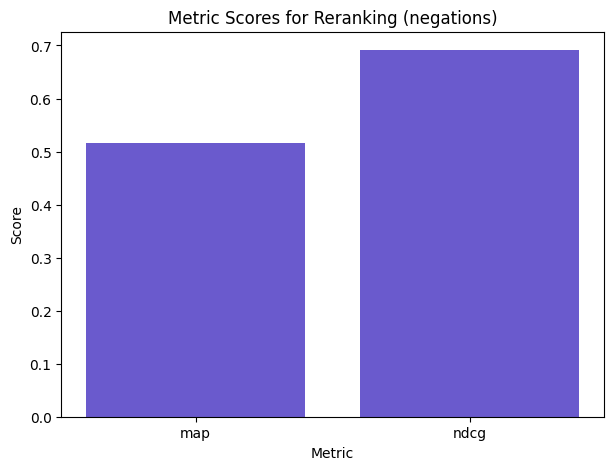

In [112]:
# PLOT
annotatedScore = {'map': 0.5166428571428571, 'ndcg': 0.6913838243505255}
categories = list(annotatedScore.keys())
values1 = list(annotatedScore.values())
#values2 = list(randomscore.values())

#increase figsize
# Define the width of the bars
# bar_width = 0.3

# Create a figure and axis
fig, ax = plt.subplots()

fig.set_size_inches(7, 5)

# Set the positions for the bars
#x = range(len(categories))
x = categories
# y axis range below 0 to -.01

# Create the bars for data1
#bars1 = plt.bar(x, values1, width=bar_width, label='Annotated Relevance', color='slateblue')
bars1 = plt.bar(x, values1, label='Annotated Relevance', color='slateblue')

# # Create the bars for data2, shifted to the right
# x_shifted = [pos + bar_width for pos in x]
# plt.xticks([pos + bar_width / 2 for pos in x], categories)
# plt.legend(loc='upper left')

plt.ylabel('Score')
plt.xlabel('Metric')
plt.title('Metric Scores for Reranking (negations)')
plt.show()